In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit


In [2]:
def generate_index(X): 
    rweights = np.random.uniform(0,1,X.shape[1])
    rweights = rweights/np.sum(rweights)

    portfolio = np.dot(X,rweights)

    return portfolio, rweights 

In [3]:
import statsmodels.api as sm

def ols_regression(X, y):
    # Add a constant column to the X matrix
    X = sm.add_constant(X)

    # Fit the OLS model
    model = sm.OLS(y, X)
    results = model.fit()

    # Return the fitted values
    return results.fittedvalues


In [4]:
from sklearn.linear_model import Ridge

def ridge_regression(X, y, alpha):
    # Create a Ridge regression model
    model = Ridge(alpha=alpha)

    # Fit the model to the data
    model.fit(X, y)

    # Predict the target variable
    y_pred = model.predict(X)

    return y_pred

In [5]:
def compute_mse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return mse

In [6]:
def compute_negative_drawdown(returns):
    cumulative_returns = np.cumsum(returns)
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = cumulative_returns - peak
    negative_drawdown = np.min(drawdown)
    return negative_drawdown

### Tried autoencoder with cross validation on how many non communal stocks do we pick (not working) 


In [7]:
from sklearn.model_selection import TimeSeriesSplit

def autoencoder_cross_val(X, Y):
    # Prepare the data
    X_train, X_test = X[:int(len(X)*0.8)], X[int(len(X)*0.8):]
    Y_train, Y_test = Y[:int(len(Y)*0.8)], Y[int(len(Y)*0.8):]

    X_train_normalized = (X_train - X_train.mean()) / X_train.std()
    X_test_normalized = (X_test - X_test.mean()) / X_test.std()

    l = len(X_train_normalized[1])
    Nb_most_comm = l/10 #take care of the trend 
    folds = 5 # 5 different numbers of least communal for cross validation  
    validation_itr_train = TimeSeriesSplit(n_splits=folds).split(X_train_normalized)
    validation_itr_test = TimeSeriesSplit(n_splits=folds).split(X_test_normalized)
    score = float('inf')

    for i, (train_idx, test_idx) in enumerate(zip(validation_itr_train, validation_itr_test)):
        print(len(X_train_normalized))
        print(len(X_test_normalized))
        print(train_idx)
        print(test_idx)

        # Build the autoencoder model

        input_dim = X_train_normalized[train_idx].shape[1]

        input_layer = layers.Input(shape=(input_dim,))
        encoder = layers.Dense(30, activation='relu')(input_layer)
        decoder = layers.Dense(input_dim, activation='sigmoid')(encoder)

        autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)

        # Compile and train the autoencoder
        autoencoder.compile(optimizer='adam', loss='mse')
        autoencoder.fit(X_train_normalized[train_idx],X_train_normalized[train_idx], epochs=10, batch_size=32, validation_data=(X_test_normalized[test_idx],X_test_normalized[test_idx]))

        print(len(X_train_normalized))
        print(len(X_train_normalized))
        print(train_idx)
        print(test_idx)

        # Extract the decoded features
        decoder_model = tf.keras.Model(inputs=input_layer, outputs=decoder)
        decoded_features_test = decoder_model.predict(X_test_normalized)
        decod_error = abs(decoded_features_test-X_test_normalized)

        sum_of_squares = np.sum(decod_error**2, axis=0)
        print(sum_of_squares.shape)

        #CROSS VALIDATION PARAMETER 
        Nb_least_comm =  (i+1)*l/10  
        Nb_most_comm = int(Nb_most_comm)
        Nb_least_comm = int(Nb_least_comm)

        # Get the indices of the features with the smallest average decoding error
        most_comm_indices = np.argsort(sum_of_squares)[:Nb_most_comm]

        # Get the indices of the features with the highest average decoding error
        least_comm_indices = np.argsort(sum_of_squares)[-Nb_least_comm:]

        selected_features = np.concatenate((most_comm_indices, least_comm_indices))
        #print(selected_features)
        selected_X_test_normalized = X_test_normalized[selected_features,test_idx]

        # De-normalize the selected_X_test_normalized
        selected_X_test_denormalized = (selected_X_test_normalized * X_train.std()) + X_train.mean()

        # Run OLS regression
        predicted_values = ols_regression(selected_X_test_denormalized.T, Y_test[test])

        #CROSS VALIDATION 

        # Compute MSE
        mse = compute_mse(predicted_values, Y_test)
 
        # Compute negative drawdown
        negative_drawdown = compute_negative_drawdown(predicted_values)

        #SELECTION CRITERIA, MUST IMPOSE PENALTY ON NUMBER OF SELCTED FEATURES (MIGHT WANT TO ACCOUNT FOR FIXED T COSTS HERE ??)

        score_n = (mse+negative_drawdown+(mse+negative_drawdown)*(Nb_least_comm/(Nb_least_comm + Nb_most_comm)))/3

        # Check if the current score is smaller than the previous iteration score 
        if score_n < score:
            score = score_n
            Nb_least_comm_val = Nb_least_comm

    # Get the indices of the features with the smallest average decoding error
    most_comm_indices = np.argsort(sum_of_squares)[:Nb_most_comm]

    # Get the indices of the features with the highest average decoding error
    least_comm_indices = np.argsort(sum_of_squares)[-Nb_least_comm:]

    selected_features = np.concatenate((most_comm_indices, least_comm_indices))
    selected_X_test_normalized = X_test_normalized[selected_features, :]

    # De-normalize the selected_X_test_normalized
    selected_X_test_denormalized = (selected_X_test_normalized * X_train.std()) + X_train.mean()

    # Print the selected features and their shape
    print("Nb_least_comm_val:", Nb_least_comm_val)
    print("Nb_most_comm:", Nb_most_comm)
    print("Shape of selected_X_test_denormalized:", selected_X_test_denormalized.shape)

    # Return the de-normalized array
    return selected_X_test_denormalized, Nb_most_comm, Nb_least_comm_val

### Simple autoencoder

In [54]:
def autoencoder(X):
    # Prepare the data
    X_train, X_test = X[:int(len(X)*0.8)], X[int(len(X)*0.8):]

    X_train_normalized = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0) #std and mean independently for each feature 
    X_test_normalized = (X_test - X_test.mean(axis=0)) / X_test.std(axis=0)

    l = len(X_train_normalized.values[1])
    Nb_most_comm = int(np.floor(l/10)) #take care of the trend 
    Nb_least_comm =  int(np.floor((0.5)*l/10)) #Take care of the high volatility components

    # Build the autoencoder model

    input_dim = X_train_normalized.shape[1]

    input_layer = layers.Input(shape=(input_dim,))
    encoder = layers.Dense(30, activation='relu')(input_layer)
    decoder = layers.Dense(input_dim, activation='sigmoid')(encoder)

    autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)

    # Compile and train the autoencoder
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(X_train_normalized,X_train_normalized, epochs=10, batch_size=32, validation_data=(X_test_normalized,X_test_normalized))


    # Extract the decoded features
    decoder_model = tf.keras.Model(inputs=input_layer, outputs=decoder)
    decoded_features_test = decoder_model.predict(X_test_normalized)
    decod_error = abs(decoded_features_test-X_test_normalized)
    
    sum_of_squares = np.sum(decod_error**2, axis=0)

    # Get the indices of the features with the smallest average decoding error
    most_comm_indices =  X_test.columns[np.argsort(sum_of_squares)[:Nb_most_comm]]

    # Get the indices of the features with the highest average decoding error
    least_comm_indices = X_test.columns[np.argsort(sum_of_squares)[-Nb_least_comm:]]

    selected_features = np.concatenate((most_comm_indices, least_comm_indices))
    selected_X_test = X_test[selected_features]

    print("Number of features in selected X_test:", selected_X_test.shape)

    # Return the de-normalized array
    return selected_X_test, Nb_most_comm, Nb_least_comm

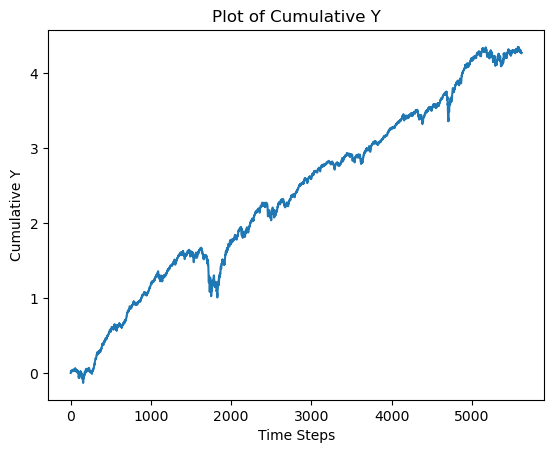

In [55]:
returns = pd.read_csv('Index_Replication_Data/X_USD.csv', index_col=0, header=0, parse_dates=True, keep_default_na=True, na_values=['NA'], delimiter=';', decimal=",")
returns.dropna(axis=1, inplace=True)
returns = returns[returns.index.dayofweek < 5]
returns.shape
X = returns.iloc[:, :-900]

index, rweights = generate_index(returns[returns.columns[-100:]])
Y = index
cumulative_y = np.cumsum(Y)

plt.plot(cumulative_y)
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Y')
plt.title('Plot of Cumulative Y')
plt.show()



In [56]:
print(X.shape)
print(Y.shape)

(5621, 84)
(5621,)


In [57]:
Res = autoencoder(X)

Epoch 1/10
141/141 [==============================] - 1s 2ms/step - loss: 1.0467 - val_loss: 0.9251
Epoch 2/10
141/141 [==============================] - 0s 2ms/step - loss: 0.8985 - val_loss: 0.8678
Epoch 3/10
141/141 [==============================] - 0s 2ms/step - loss: 0.8561 - val_loss: 0.8414
Epoch 4/10
141/141 [==============================] - 0s 2ms/step - loss: 0.8368 - val_loss: 0.8281
Epoch 5/10
141/141 [==============================] - 0s 1ms/step - loss: 0.8244 - val_loss: 0.8180
Epoch 6/10
141/141 [==============================] - 0s 2ms/step - loss: 0.8145 - val_loss: 0.8090
Epoch 7/10
141/141 [==============================] - 0s 2ms/step - loss: 0.8060 - val_loss: 0.8010
Epoch 8/10
141/141 [==============================] - 0s 2ms/step - loss: 0.7987 - val_loss: 0.7943
Epoch 9/10
141/141 [==============================] - 0s 2ms/step - loss: 0.7925 - val_loss: 0.7885
Epoch 10/10
36/36 [==============================] - 0s 861us/step
Number of features in selected X_

array([-0.00138738, -0.00536368,  0.00382911, ..., -0.00422566,
       -0.00506308,  0.0040773 ])

2019-05-30    0.004799
2019-05-31   -0.001127
2019-06-03    0.001724
2019-06-04    0.009349
2019-06-05    0.002595
                ...   
2023-09-14    0.003329
2023-09-15    0.003936
2023-09-18   -0.001086
2023-09-19    0.005232
2023-09-20    0.010588
Length: 1125, dtype: float64

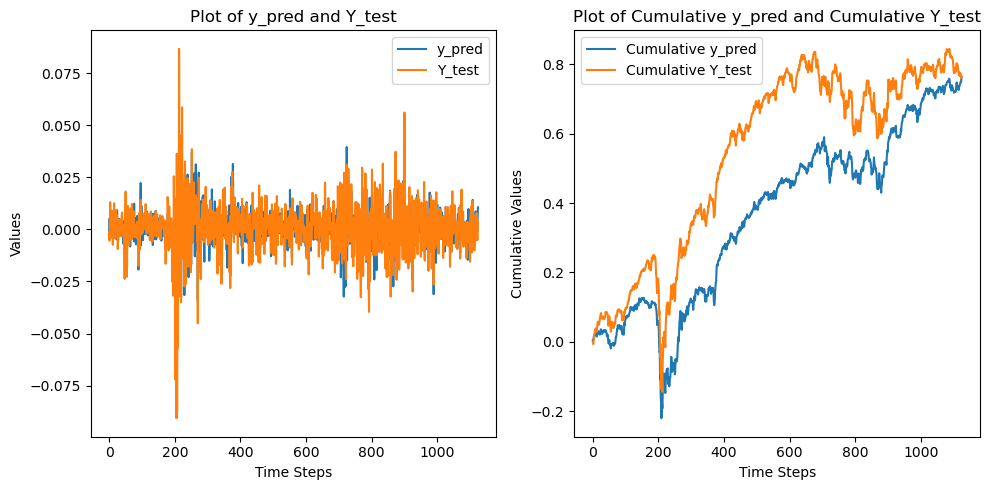

Number of selected features: 12
Tracking Error: 5.9448349792527135e-05


In [58]:
selected_X_test_denormalized, _, Nb_least_comm_val = Res


Y_test = Y[int(len(Y)*0.8):]
display(Y_test)

predicted_values = ols_regression(selected_X_test_denormalized, Y_test)

display(predicted_values)

# Plot the predicted values and Y_test
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(predicted_values.values, label='y_pred')
plt.plot(Y_test, label='Y_test')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.title('Plot of y_pred and Y_test')
plt.legend()

# Compute the cumulative values
cumulative_predicted_values = np.cumsum(predicted_values.values)
cumulative_Y_test = np.cumsum(Y_test)

plt.subplot(1, 2, 2)
plt.plot(cumulative_predicted_values, label='Cumulative y_pred')
plt.plot(cumulative_Y_test, label='Cumulative Y_test')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Values')
plt.title('Plot of Cumulative y_pred and Cumulative Y_test')
plt.legend()

plt.tight_layout()
plt.show()

print("Number of selected features:", len(selected_X_test_denormalized.columns))

tracking_error = compute_mse(predicted_values, Y_test)
print("Tracking Error:", tracking_error)



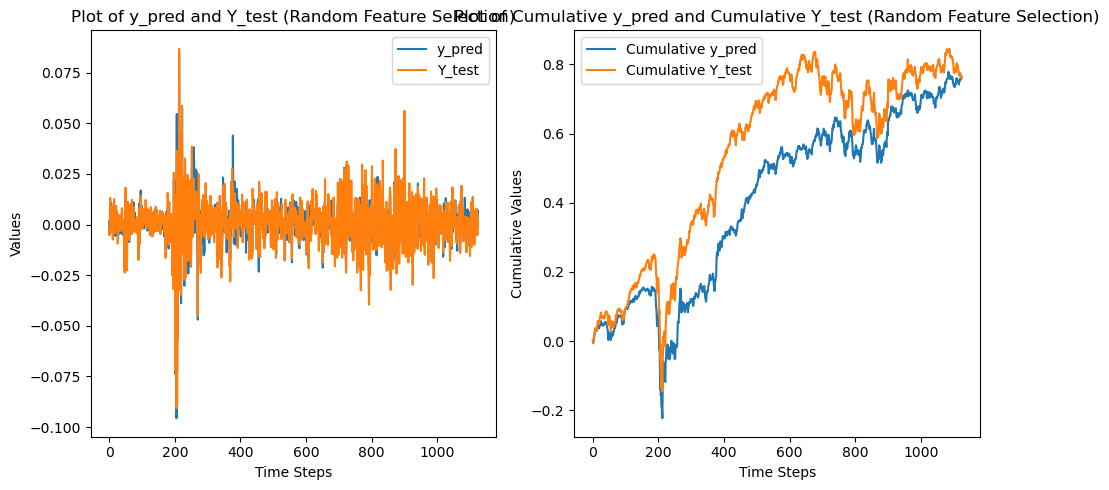

Number of randomly selected features: 12
Tracking Error (Random Feature Selection): 3.62999750965972e-05


In [59]:
import random

def random_feature_selection(X, num_features):
    # Get the column names of X
    columns = X.columns.tolist()

    # Select num_features randomly from the columns
    selected_features = random.sample(columns, num_features)

    # Return the selected features
    return X[selected_features]


X_test = X[int(len(X)*0.8):]

# Perform the same task as the previous cell
selected_X_test_random = random_feature_selection(X_test, len(selected_X_test_denormalized.columns))
predicted_values_random = ols_regression(selected_X_test_random, Y_test)

# Plot the predicted values and Y_test
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(predicted_values_random.values, label='y_pred')
plt.plot(Y_test, label='Y_test')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.title('Plot of y_pred and Y_test (Random Feature Selection)')
plt.legend()

# Compute the cumulative values
cumulative_predicted_values_random = np.cumsum(predicted_values_random.values)

plt.subplot(1, 2, 2)
plt.plot(cumulative_predicted_values_random, label='Cumulative y_pred')
plt.plot(cumulative_Y_test, label='Cumulative Y_test')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Values')
plt.title('Plot of Cumulative y_pred and Cumulative Y_test (Random Feature Selection)')
plt.legend()

plt.tight_layout()
plt.show()

print("Number of randomly selected features:", len(selected_X_test_random.columns))
tracking_error_random = compute_mse(predicted_values_random, Y_test)
print("Tracking Error (Random Feature Selection):", tracking_error_random)
